<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-5/blob/main/Datathon_5_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Load in data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #5/mhealth.csv')

# drop subject 9 bc their distribution is different from the others
data = data[data['subject'] != 'subject9']

print(data.shape)
data.head()

(982273, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [ ]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Split into Training and Testing


---



In [35]:
from sklearn.model_selection import train_test_split

# Grouping by 'subject' and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((753408, 14), (228865, 14))

Normalization

---



In [36]:
from sklearn.preprocessing import StandardScaler

# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df.select_dtypes(include=['float64']).columns.tolist()

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
print(train_df.shape)
train_df.head()

(753408, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,0.214821,-0.022355,0.309939,0.244241,-0.668159,-1.036175,-1.098917,0.233330,-0.594683,-0.335191,-1.016340,-0.471094,0,subject1
1,0.267516,0.023418,0.319902,0.207517,-0.662733,-1.028975,-1.094306,0.278958,-0.636633,-0.335191,-1.016340,-0.471094,0,subject1
2,0.272975,0.009010,0.319384,0.207517,-0.662733,-1.028975,-1.069191,0.286484,-0.572206,-0.335191,-1.016340,-0.471094,0,subject1
3,0.213911,0.042315,0.294847,0.207517,-0.662733,-1.028975,-1.094388,0.279577,-0.548748,-0.349689,-1.012564,-0.486675,0,subject1
4,0.275237,0.052309,0.324983,0.207517,-0.662733,-1.028975,-1.109395,0.309677,-0.538585,-0.349689,-1.012564,-0.486675,0,subject1


Sequence Creation & Addressing Class Imbalance

---



In [61]:
import random

np.random.seed(42)

sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(data, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # Assuming 'Activity' is the target variable and is the same for the entire sequence
        label = sequence['Activity'].max()

        # Undersampling label 0
        if label != 0 or random.random() > 0.95: # undersample the 0 labels where there is a 95% chance to drop
          sequences.append(sequence[sensor_columns].values)
          output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100)
X_test, y_test = create_sequences(test_df, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2418, 100, 12), (2418,), (792, 100, 12), (792,))

<Axes: ylabel='Count'>

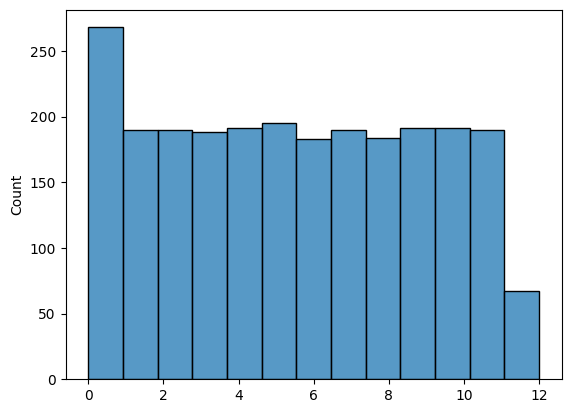

In [62]:
import seaborn as sns
# print("First few rows and columns of X_train:")
# for i in range(len(y_train)):
#   print(y_train[i])

sns.histplot(y_train)